# 猫狗大战
## class 1 数据处理类

In [1]:
import os
import random
import numpy as np
from PIL import Image
from keras.applications import Xception, xception
from matplotlib import pyplot as plt
import pickle as pkl
import pyprind
%matplotlib inline
'''
该类主要负责构造验证集,创建数据生成器及异常值处理
'''
class Dataset:
    def __init__(self):
        self.train_data_file, self.val_data_file = [], []
        self.train_path = '/data/glj/dogsVScats/train/'
        self.test_path = '/data/glj/dogsVScats/test/'
        self.filelist = os.listdir(self.train_path)

    # 分割验证集
    def split_val_data(self, random_seed=None, val_rate=0.2):
        filelist = self.filelist
        filelist = sorted(filelist)
        random.seed(random_seed)
        random.shuffle(filelist)
        self.train_data_file = filelist[:int((1 - val_rate) * len(filelist))]
        self.val_data_file = filelist[int((1 - val_rate) * len(filelist)):]
        self.test_data_file = os.listdir(self.test_path)
        print('Total training images:{}'.format(len(self.train_data_file)))
        print('Total val images:{}'.format(len(self.val_data_file)))
        print('Total test images:{}'.format(len(self.test_data_file)))

    # 加载数据:mode=='trian'加载训练数据, =='val'加载验证数据
    def data_generator(self, batch_size, mode, shape=(224, 224), preprocess_input=None):
        filelist = []
        if mode == 'train':
            filelist = self.train_data_file
        elif mode == 'val':
            filelist = self.val_data_file
        else:
            print('Wrong Mode!')
            return
        while True:
            count = 0
            datas, labels = [], []
            for file in filelist:
                im = Image.open(self.train_path + file)
                im = im.resize(shape)
                img = np.array(im, np.float)
                img = preprocess_input(img)

                if file.split('.')[0] == 'cat':
                    label = np.array([0], dtype=np.int8)
                else:
                    label = np.array([1], dtype=np.int8)
                datas.append(img)
                labels.append(label)
                count += 1
                if count >= batch_size:
                    datas = np.array(datas).reshape([-1, shape[0], shape[1], 3])
                    labels = np.array(labels)
                    yield (datas, labels)
                    count = 0
                    datas = []
                    labels = []

    # 加载测试集
    def test_generator(self, batch_size, shape=(224, 224), preprocess_input=None):
        count = 0
        datas = []
        filelist = self.test_data_file
        for i in range(len(filelist)):
            filelist[i] = int(filelist[i].split('.')[0])
        filelist = sorted(filelist)
        
        for file in filelist:
            im = Image.open(self.test_path + str(file) + '.jpg')
            im = im.resize(shape)
            img = np.array(im, np.float)
            img = preprocess_input(img)

            datas.append(img)
            count += 1
            if count >= batch_size:
                datas = np.array(datas).reshape([-1, shape[0], shape[1], 3])
                yield (datas)
                count = 0
                datas = []

    # 异常图片处理：使用Xception预训练模型对训练集进行检测
    def outlier_detection(self,top,max_counts):
        # 1.首先定义ImageNet中猫狗的ID：
        # 来源于https://blog.csdn.net/zhangjunbob/article/details/53258524
        dogs = [
            'n02085620', 'n02085782', 'n02085936', 'n02086079'
            , 'n02086240', 'n02086646', 'n02086910', 'n02087046'
            , 'n02087394', 'n02088094', 'n02088238', 'n02088364'
            , 'n02088466', 'n02088632', 'n02089078', 'n02089867'
            , 'n02089973', 'n02090379', 'n02090622', 'n02090721'
            , 'n02091032', 'n02091134', 'n02091244', 'n02091467'
            , 'n02091635', 'n02091831', 'n02092002', 'n02092339'
            , 'n02093256', 'n02093428', 'n02093647', 'n02093754'
            , 'n02093859', 'n02093991', 'n02094114', 'n02094258'
            , 'n02094433', 'n02095314', 'n02095570', 'n02095889'
            , 'n02096051', 'n02096177', 'n02096294', 'n02096437'
            , 'n02096585', 'n02097047', 'n02097130', 'n02097209'
            , 'n02097298', 'n02097474', 'n02097658', 'n02098105'
            , 'n02098286', 'n02098413', 'n02099267', 'n02099429'
            , 'n02099601', 'n02099712', 'n02099849', 'n02100236'
            , 'n02100583', 'n02100735', 'n02100877', 'n02101006'
            , 'n02101388', 'n02101556', 'n02102040', 'n02102177'
            , 'n02102318', 'n02102480', 'n02102973', 'n02104029'
            , 'n02104365', 'n02105056', 'n02105162', 'n02105251'
            , 'n02105412', 'n02105505', 'n02105641', 'n02105855'
            , 'n02106030', 'n02106166', 'n02106382', 'n02106550'
            , 'n02106662', 'n02107142', 'n02107312', 'n02107574'
            , 'n02107683', 'n02107908', 'n02108000', 'n02108089'
            , 'n02108422', 'n02108551', 'n02108915', 'n02109047'
            , 'n02109525', 'n02109961', 'n02110063', 'n02110185'
            , 'n02110341', 'n02110627', 'n02110806', 'n02110958'
            , 'n02111129', 'n02111277', 'n02111500', 'n02111889'
            , 'n02112018', 'n02112137', 'n02112350', 'n02112706'
            , 'n02113023', 'n02113186', 'n02113624', 'n02113712'
            , 'n02113799', 'n02113978']
        cats = [
            'n02123045', 'n02123159', 'n02123394', 'n02123597'
            , 'n02124075', 'n02125311', 'n02127052']
        outliers = []
        pure_files = []
        count = 1
        progress_bar = pyprind.ProgBar(max_counts)
        # 2.载入xception预训练模型：
        xnet = Xception(weights='imagenet')
        # 3.读取图片进行预测:
        filelist = self.filelist
        for file in filelist:
            im = Image.open(self.train_path + file)
            im = im.resize((299, 299))
            img = np.reshape(np.array(im, np.float), (1, 299, 299, 3))
            img = xception.preprocess_input(img)
            preds = xnet.predict(img)
            preds_class = xception.decode_predictions(preds, top=top)[0]
            is_outlier = True
            for i in range(len(preds_class)):
                if preds_class[i][0] in cats or preds_class[i][0] in dogs:
                    is_outlier = False
                    break
            if is_outlier:
                outliers.append(file)
                # 只画出其中5张异常图
                if len(outliers)<=5:
                    plt.imshow(im)
                    plt.show()
                    print(file)
            else:
                pure_files.append(file)
            count += 1
            progress_bar.update()
            if count == max_counts:
                print('Detected {count} images.'.format(count=count))
                print('Total outliers {}'.format(len(outliers)))
                files = {'pure_files':pure_files,'outliers':outliers}
                with open('outliers.pkl','wb') as f:
                    pkl.dump(files,f)

Using TensorFlow backend.


##  class 2 模型父类 用于各模型继承

In [2]:
from keras import Model
from keras.optimizers import Adam
import pandas as pd
import os
import numpy as np
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import *
import pickle as pkl

'''
该类主要负责初始化超参数、定义训练模型、测试模型以及画出训练结果图，供各子类模型继承
'''

class MODELS():
    def __init__(self,parms):
        self.lr = parms['learning_rate']
        self.batch_size = parms['batch_size']
        self.epoch = parms['epoch']
        self.verbose = parms['verbose']
        self.dropout_rate = 0.5
        self.totals = 25000 - 52 # 52 个异常图片
        self.ntest = 12500
        self.name = ''
        self.info = ''
        self.model = self.build_model()
        
    def build_model(self):
        x = Input([1,1])
        output = Dense(1)(x)
        model = Model(inputs=x,outputs=output)
        return model
    
    def train_generator(self,train_generator,val_generator,val_rate):
        earlystopping = EarlyStopping('val_loss', patience=4)
        self.weights_path = '/data/glj/dogsVScats/results/'+\
                            self.name+'/'+self.info+\
                            '_weights_pretrained.best.h5'
        self.hist_path = 'results/'+self.name+'/hist_'+self.info+\
                         '_weights_pretrained.pkl'
        cp = ModelCheckpoint(self.weights_path,save_best_only=True,
                             save_weights_only=True,verbose=1)
        calls = [earlystopping,cp]
        batch_nums_train = np.ceil(self.totals*(1-val_rate)/self.batch_size)
        batch_nums_val = np.ceil(self.totals*val_rate/self.batch_size)
        hist = self.model.fit_generator(train_generator,
                                        steps_per_epoch=batch_nums_train,
                                        validation_data=val_generator,
                                        validation_steps=batch_nums_val,
                                        epochs=self.epoch,
                                        verbose=self.verbose,shuffle=True,
                                        callbacks=calls)
        with open(self.hist_path, 'wb') as f:
            pkl.dump(hist.history,f)
        print(self.name+' Model trained Done!')

    def predict_by_gen(self,generator,load_weights=False):
        filelist = os.listdir('/data/glj/dogsVScats/test/')
        self.preds_paht = 'results/'+self.name+'/'+self.info+'_preds.csv'
        ids = np.arange(1,len(filelist)+1,dtype=int)
        probs = np.zeros(len(filelist),dtype=np.float16)
        if load_weights:
            try:
                self.model.load_weights(self.weights_path)
            except IOError:
                print('Without weights file!')
                return
        probs = self.model.predict_generator(generator,steps=self.ntest/self.batch_size,
                                             verbose=self.verbose)
        probs = np.clip(np.reshape(probs, len(probs)), 0.005, 0.995)
        df = pd.DataFrame({'id':ids,'label':probs})
        df.to_csv(self.preds_paht,index=False)
        print(self.name+' Model test Done!')
    
    def plot_training_results(self):
        with open(self.hist_path, 'rb') as f:
            hist = pkl.load(f)
        loss = hist['loss']
        acc = hist['binary_accuracy']
        val_loss = hist['val_loss']
        plt.subplot(211)
        plt.plot(acc, color='green', label='training accurate')
        plt.legend(loc='lower right', frameon=False)

        plt.subplot(212)
        plt.plot(loss, color='red', label='trianing loss')
        plt.plot(val_loss,color='blue',linewidth=2,label='val loss')
        plt.legend(loc='upper right', frameon=False)
        plt.show()
    def upgrade_paths(self):
        name = self.name
        info = self.info
        self.weights_path = '/data/glj/dogsVScats/results/'+name+'/'+info+'_weights_pretrained.best.h5'
        self.hist_path = 'results/'+name+'/hist_'+info+'_weights_pretrained.pkl'
        self.preds_paht = 'results/'+name+'/'+info+'_preds.csv'

## 开始！
### 1.读取数据

In [6]:
# 创建Dataset对象
dt = Dataset()

## 2.异常值分析

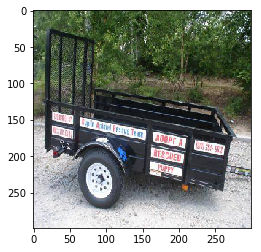

dog.1194.jpg


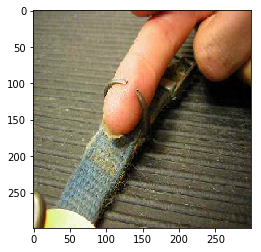

dog.10801.jpg


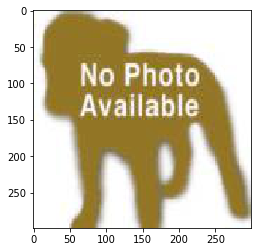

dog.8898.jpg


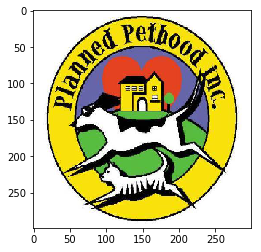

cat.4688.jpg


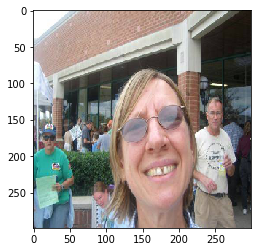

dog.12376.jpg


0% [##############################] 100% | ETA: 00:00:00

Detected 25000 images.
Total outliers 52



Total time elapsed: 00:09:34


In [22]:
# 检测异常值
# top 取30,输出其中5张异常值
dt.outlier_detection(max_counts=25000,top=30)

In [7]:
# 加载非异常数据
files = pkl.load(open('outliers.pkl','rb'))
dt.filelist = files['pure_files']

In [8]:
#划分验证集
dt.split_val_data(random_seed=333,val_rate=0.2)

Total training images:19957
Total val images:4990
Total test images:12500


## 3.数据可视化
### 对样本数、样本尺寸做分析

In [7]:
# 统计猫和狗各有多少张图片
def show_samples_num(filelists):
    cat_nums, dog_nums = 0,0
    for file in filelists:
        if file.split('.')[0] =='cat':
            cat_nums += 1
        else:
            dog_nums +=1
    x = [1,2]
    y = [cat_nums,dog_nums]
    plt.title('Numbers of each class')
    plt.bar(x,y,color='rb',
            tick_label=['cat','dog'],width=0.5)
    for x,y in zip(x,y):
        plt.text(x, y + 0.05, '%.0f' % y, ha='center', va='bottom', fontsize=11)
    plt.show()


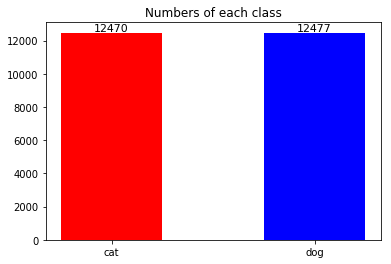

In [8]:
show_samples_num(dt.filelist)

从上面的图可以明显看出，过滤了异常数据后，样本数量依旧是均衡的。

In [9]:
# 统计样本不同尺寸的分布
def show_samples_size(path):
    filelists = os.listdir(path)

    size_x_list = []
    size_y_list = []
    for file in filelists:
        im = Image.open(path+file)
        size = im.size
        size_x_list.append(size[0])
        size_y_list.append(size[1])
    plt.title('Size of samples')
    plt.scatter(size_x_list,size_y_list)
    plt.show()

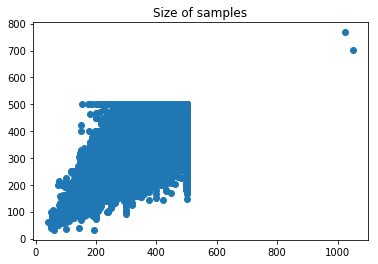

In [10]:
# 统计训练集图片大小的分布
show_samples_size('train/')

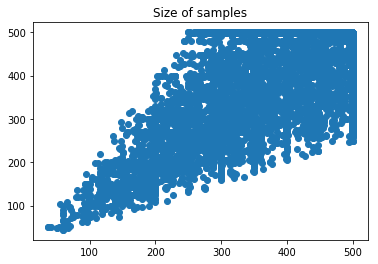

In [11]:
# 统计测试集图片大小的分布
show_samples_size('test/')

从上面两张图可以明显看出，若不对图片大小调整到同一尺寸，模型将无法训练。尤其训练集中还有两种图片尤其大。

## 3.搭建模型

### 导入四种备用模型 VGGNet19，ResNet50，Inception V3，Xception

In [3]:
from keras.applications import VGG19,ResNet50,InceptionV3,Xception
from keras.applications import vgg19,resnet50,inception_v3,xception

## 4.使用预训练的VGG19迁移学习

In [80]:
class VGGNet(MODELS):
    def __init__(self,parms):
        MODELS.__init__(self,parms)
        self.name = 'vgg'
        self.info = self.name
        self.model = self.build_model()
    def build_model(self):
        input = Input(shape=[224, 224, 3])
        base_model = VGG19(include_top=False,weights='imagenet',input_tensor=input)
        #x = GlobalAveragePooling2D()(base_model.output)
        output = Dense(200)(base_model.output)
        
        adam = Adam(lr=self.lr)
        vgg = Model(inputs=input,outputs=output)
        vgg.compile(optimizer=adam,loss='binary_crossentropy',metrics=['binary_accuracy'])
        vgg.summary()

        return vgg

### 4.1创建数据生成器

In [36]:
# 初始化参数
parms = {
    'learning_rate': 0.0001,
    'batch_size': 100,
    'epoch': 15,
    'verbose': 1,
}
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
# 创建训练集数据生成器
train_generator = dt.data_generator(batch_size=parms['batch_size'],
                                    mode='train',preprocess_input=vgg19.preprocess_input)
# 创建验证集数据生成器
val_generator = dt.data_generator(batch_size=parms['batch_size'],
                                  mode='val',preprocess_input=vgg19.preprocess_input)
# 创建测试集数据生成器
test_generator = dt.test_generator(batch_size=parms['batch_size'],
                                   preprocess_input=vgg19.preprocess_input)

### 4.2创建VGG19对象

In [81]:
vgg = VGGNet(parms)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### 4.3训练VGG19网络

In [38]:
vgg.train_generator(train_generator,val_generator,val_rate=0.2)

Epoch 1/15
200/200 [==============================] - 232s 1s/step - loss: 0.6073 - binary_accuracy: 0.6994 - val_loss: 0.5044 - val_binary_accuracy: 0.7418

Epoch 00001: val_loss improved from inf to 0.50438, saving model to results/vgg/vgg_weights_pretrained.best.h5
Epoch 2/15
200/200 [==============================] - 225s 1s/step - loss: 0.2932 - binary_accuracy: 0.8776 - val_loss: 0.1775 - val_binary_accuracy: 0.9266

Epoch 00002: val_loss improved from 0.50438 to 0.17745, saving model to results/vgg/vgg_weights_pretrained.best.h5
Epoch 3/15
200/200 [==============================] - 225s 1s/step - loss: 0.1187 - binary_accuracy: 0.9555 - val_loss: 0.0897 - val_binary_accuracy: 0.9670

Epoch 00003: val_loss improved from 0.17745 to 0.08967, saving model to results/vgg/vgg_weights_pretrained.best.h5
Epoch 4/15
200/200 [==============================] - 226s 1s/step - loss: 0.0766 - binary_accuracy: 0.9700 - val_loss: 0.0707 - val_binary_accuracy: 0.9746

Epoch 00004: val_loss impro

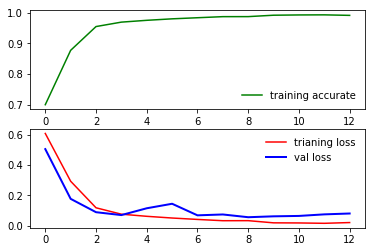

In [39]:
# 可视化训练结果
vgg.plot_training_results()

### 4.4测试VGG19网络

In [40]:
vgg.predict_by_gen(test_generator,load_weights=True)
# Kaggle score:0.08114

125/125 [==============================] - 48s 388ms/step
vgg Model test Done!


## 5.使用预训练的ResNet50迁移学习

In [7]:
class ResNet(MODELS):
    def __init__(self,parms):
        MODELS.__init__(self,parms)
        self.name = 'resnet50'
        self.info = self.name
        self.model = self.build_model()
    def build_model(self):
        base_model = ResNet50(input_tensor=Input((224,224,3)),
                              weights='imagenet',include_top=False)
        x = GlobalAveragePooling2D()(base_model.output)
        output = Dense(1,activation='sigmoid')(x)
        resnet50 = Model(base_model.input,output)

        adam = Adam(lr=self.lr)
        resnet50.compile(optimizer=adam,loss='binary_crossentropy',
                         metrics=['binary_accuracy'])
        resnet50.summary()
        return resnet50

### 5.1创建数据生成器

In [8]:
# 初始化参数
parms = {
    'learning_rate': 0.0001,
    'batch_size': 100,
    'epoch': 15,
    'verbose': 1
}
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
# 创建训练集数据生成器
train_generator = dt.data_generator(batch_size=parms['batch_size'],
                                    mode='train',preprocess_input=resnet50.preprocess_input)
# 创建验证集数据生成器
val_generator = dt.data_generator(batch_size=parms['batch_size'],
                                  mode='val',preprocess_input=resnet50.preprocess_input)
# 创建测试集数据生成器
test_generator = dt.test_generator(batch_size=parms['batch_size'],
                                   preprocess_input=resnet50.preprocess_input)

### 5.2创建ResNet对象

In [9]:
resnet = ResNet(parms)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
res5b_branch2a (Conv2D)         (None, 7, 7, 512)    1049088     activation_43[0][0]              
__________________________________________________________________________________________________
bn5b_branch2a (BatchNormalizati (None, 7, 7, 512)    2048        res5b_branch2a[0][0]             
__________________________________________________________________________________________________
activation_44 (Activation)      (None, 7, 7, 512)    0           bn5b_branch2a[0][0]              
__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 7, 7, 512)    2359808     activation_44[0][0]              
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 7, 7, 512)    2048        res5b_branch2b[0][0]             
__________

### 5.3训练ResNet

In [45]:
resnet.train_generator(train_generator,val_generator,val_rate=0.2)

Epoch 1/15
200/200 [==============================] - 196s 979ms/step - loss: 0.0536 - binary_accuracy: 0.9810 - val_loss: 0.0353 - val_binary_accuracy: 0.9870

Epoch 00001: val_loss improved from inf to 0.03529, saving model to results/resnet50/resnet50_weights_pretrained.best.h5
Epoch 2/15
200/200 [==============================] - 190s 949ms/step - loss: 0.0061 - binary_accuracy: 0.9981 - val_loss: 0.0347 - val_binary_accuracy: 0.9898

Epoch 00002: val_loss improved from 0.03529 to 0.03467, saving model to results/resnet50/resnet50_weights_pretrained.best.h5
Epoch 3/15
200/200 [==============================] - 191s 953ms/step - loss: 0.0033 - binary_accuracy: 0.9990 - val_loss: 0.3029 - val_binary_accuracy: 0.9538

Epoch 00003: val_loss did not improve from 0.03467
Epoch 4/15
200/200 [==============================] - 190s 950ms/step - loss: 0.0071 - binary_accuracy: 0.9980 - val_loss: 0.0566 - val_binary_accuracy: 0.9844

Epoch 00004: val_loss did not improve from 0.03467
Epoch 5/

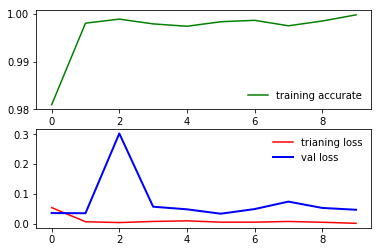

In [46]:
# 可视化训练结果
resnet.plot_training_results()

### 5.4测试ResNet

In [10]:
resnet.predict_by_gen(test_generator,load_weights=True)
# Kaggle score:0.05515

125/125 [==============================] - 49s 393ms/step
resnet50 Model test Done!


## 6.使用Inception V3进行迁移学习

In [8]:
class InetV3(MODELS):
    def __init__(self,parms):
        MODELS.__init__(self,parms)
        self.name = 'inception'
        self.info = self.name
        self.model = self.build_model()
    def build_model(self):
        base_model = InceptionV3(input_tensor=Input((299,299,3)),
                                 weights='imagenet',include_top=False)
        x = GlobalAveragePooling2D()(base_model.output)
        x = Dropout(0.25)(x)
        output = Dense(1,activation='sigmoid')(x)
        iv3 = Model(base_model.input,output)

        adam = Adam(lr=self.lr)
        iv3.compile(optimizer=adam,loss='binary_crossentropy',
                    metrics=['binary_accuracy'])
        iv3.summary()
        return iv3

### 6.1创建数据生成器

In [9]:
# 初始化参数
parms = {
    'learning_rate': 0.0001,
    'batch_size': 50,
    'epoch': 10,
    'verbose': 1
}
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
# 创建训练集数据生成器
train_generator = dt.data_generator(batch_size=parms['batch_size'],
                                    mode='train',shape=(299,299),
                                    preprocess_input=inception_v3.preprocess_input)
# 创建验证集数据生成器
val_generator = dt.data_generator(batch_size=parms['batch_size'],
                                  mode='val',shape=(299,299),
                                  preprocess_input=inception_v3.preprocess_input)
# 创建测试集数据生成器
test_generator = dt.test_generator(batch_size=parms['batch_size'],
                                   shape=(299,299),
                                   preprocess_input=inception_v3.preprocess_input)

### 6.2创建Inception V3对象

In [10]:
inception = InetV3(parms)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 35, 35, 64)   18432       mixed2[0][0]                     
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 35, 35, 64)   192         conv2d_28[0][0]                  
__________________________________________________________________________________________________
activation_28 (Activation)      (None, 35, 35, 64)   0           batch_normalization_28[0][0]     
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 35, 35, 96)   55296       activation_28[0][0]              
__________________________________________________________________________________________________
batch_normalization_29 (BatchNo (None, 35, 35, 96)   288         conv2d_29[0][0]                  
__________

### 6.3训练Inception V3

In [14]:
inception.train_generator(train_generator,val_generator,val_rate=0.2)

Epoch 1/10
400/400 [==============================] - 314s 786ms/step - loss: 0.0449 - binary_accuracy: 0.9834 - val_loss: 0.0228 - val_binary_accuracy: 0.9910

Epoch 00001: val_loss improved from inf to 0.02275, saving model to results/inception/inception_weights_pretrained.best.h5
Epoch 2/10
400/400 [==============================] - 303s 757ms/step - loss: 0.0098 - binary_accuracy: 0.9969 - val_loss: 0.0712 - val_binary_accuracy: 0.9784

Epoch 00002: val_loss did not improve from 0.02275
Epoch 3/10
400/400 [==============================] - 303s 757ms/step - loss: 0.0082 - binary_accuracy: 0.9974 - val_loss: 0.0290 - val_binary_accuracy: 0.9924

Epoch 00003: val_loss did not improve from 0.02275
Epoch 4/10
400/400 [==============================] - 303s 757ms/step - loss: 0.0055 - binary_accuracy: 0.9980 - val_loss: 0.0637 - val_binary_accuracy: 0.9858

Epoch 00004: val_loss did not improve from 0.02275
Epoch 5/10
400/400 [==============================] - 304s 760ms/step - loss: 0.

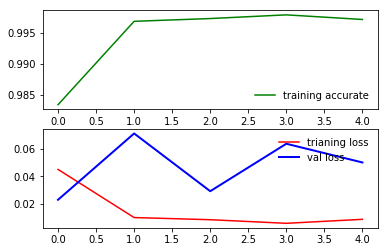

In [15]:
# 可视化训练结果
inception.plot_training_results()

### 6.4测试Inception V3

In [11]:
inception.predict_by_gen(test_generator,load_weights=True)
# Kaggle score:0.04436

250/250 [==============================] - 70s 279ms/step
inception Model test Done!


## 7.使用Xception进行迁移学习

In [7]:
class Xnet(MODELS):
    def __init__(self,parms):
        MODELS.__init__(self,parms)
        self.name = 'xception'
        self.info = self.name
        self.model = self.build_model()
    def build_model(self):
        base_model = Xception(input_tensor=Input((299,299,3)),
                              weights='imagenet',include_top=False)
        x = GlobalAveragePooling2D()(base_model.output)
        x = Dropout(0.25)(x)
        output = Dense(1,activation='sigmoid')(x)
        xnet = Model(base_model.input,output)

        adam = Adam(lr=self.lr)
        xnet.compile(optimizer=adam,loss='binary_crossentropy',
                     metrics=['binary_accuracy'])
        xnet.summary()
        return xnet

### 7.1创建数据生成器

In [8]:
# 初始化参数
parms = {
    'learning_rate': 0.0001,
    'batch_size': 25,
    'epoch': 10,
    'verbose': 1
}
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
# 创建训练集数据生成器
train_generator = dt.data_generator(batch_size=parms['batch_size'],
                                    mode='train',shape=(299,299),
                                    preprocess_input=xception.preprocess_input)
# 创建验证集数据生成器
val_generator = dt.data_generator(batch_size=parms['batch_size'],
                                  mode='val',shape=(299,299),
                                  preprocess_input=xception.preprocess_input)
# 创建测试集数据生成器
test_generator = dt.test_generator(batch_size=parms['batch_size'],
                                   shape=(299,299),
                                   preprocess_input=xception.preprocess_input)

### 7.2创建Xception对象

In [9]:
xnet = Xnet(parms)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

add_6 (Add)                     (None, 19, 19, 728)  0           block7_sepconv3_bn[0][0]         
                                                                 add_5[0][0]                      
__________________________________________________________________________________________________
block8_sepconv1_act (Activation (None, 19, 19, 728)  0           add_6[0][0]                      
__________________________________________________________________________________________________
block8_sepconv1 (SeparableConv2 (None, 19, 19, 728)  536536      block8_sepconv1_act[0][0]        
__________________________________________________________________________________________________
block8_sepconv1_bn (BatchNormal (None, 19, 19, 728)  2912        block8_sepconv1[0][0]            
__________________________________________________________________________________________________
block8_sepconv2_act (Activation (None, 19, 19, 728)  0           block8_sepconv1_bn[0][0]         
__________

### 7.3训练Xception

In [28]:
xnet.train_generator(train_generator,val_generator,val_rate=0.2)

Epoch 1/10
799/799 [==============================] - 541s 677ms/step - loss: 0.0401 - binary_accuracy: 0.9869 - val_loss: 0.0199 - val_binary_accuracy: 0.9930

Epoch 00001: val_loss improved from inf to 0.01985, saving model to results/xception/xception_weights_pretrained.best.h5
Epoch 2/10
799/799 [==============================] - 532s 666ms/step - loss: 0.0067 - binary_accuracy: 0.9982 - val_loss: 0.0286 - val_binary_accuracy: 0.9914

Epoch 00002: val_loss did not improve from 0.01985
Epoch 3/10
799/799 [==============================] - 531s 664ms/step - loss: 0.0032 - binary_accuracy: 0.9989 - val_loss: 0.0259 - val_binary_accuracy: 0.9940

Epoch 00003: val_loss did not improve from 0.01985
Epoch 4/10
799/799 [==============================] - 531s 665ms/step - loss: 0.0042 - binary_accuracy: 0.9987 - val_loss: 0.0245 - val_binary_accuracy: 0.9944

Epoch 00004: val_loss did not improve from 0.01985
Epoch 5/10
799/799 [==============================] - 530s 663ms/step - loss: 0.00

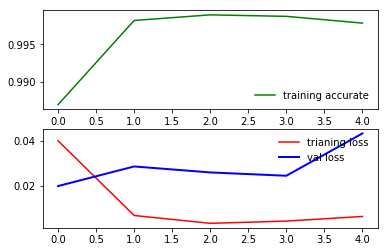

In [29]:
# 可视化训练结果
xnet.plot_training_results()

### 7.4测试Xception

In [10]:
xnet.predict_by_gen(test_generator,load_weights=True)
# Kaggle score: 0.04200

500/500 [==============================] - 91s 182ms/step
xception Model test Done!


## 8.融合Xception模型和Inception V3

In [30]:
class XIV3net(MODELS):
    def __init__(self,parms,dropout_rate):
        MODELS.__init__(self,parms)
        self.name = 'xiv3net'
        self.info = self.name
        self.model = self.build_model()
        self.dropout_rate = dropout_rate
    def build_model(self):
        input = Input((299,299,3))

        # 加载训练好的Inception模型及权重
        inception = InceptionV3(input_tensor=input,weights=None,include_top=False)
        x = GlobalAveragePooling2D()(inception.output)
        x = Dropout(self.dropout_rate)(x)
        i_out = Dense(1, activation='sigmoid')(x)
        iv3 = Model(input, i_out)
        iv3.load_weights('/data/glj/dogsVScats/results/inception'+\
                         '/inception_weights_pretrained.best.h5')

        # 加载训练好的Xception模型及权重
        xception = Xception(input_tensor=input, weights=None, include_top=False)
        x = GlobalAveragePooling2D()(xception.output)
        x = Dropout(self.dropout_rate)(x)
        x_out = Dense(1, activation='sigmoid')(x)
        xnet = Model(xception.input, x_out)
        xnet.load_weights('/data/glj/dogsVScats/results/xception'+\
                         '/xception_weights_pretrained.best.h5')
        
        # 锁层，融合模型只需要让这两个模型做特征提取器，做特征层的融合，训练时只训练特征融合层之后的参数
        for layer in xnet.layers:
            layer.trainable = False
        for layer in iv3.layers:
            layer.trainable = False
        # 去掉单独模型的top分类层
        x1 = GlobalAveragePooling2D()(iv3.layers[-4].output)
        x2 = GlobalAveragePooling2D()(xnet.layers[-4].output)

        merged_x = Concatenate(axis=1)([x1,x2])
        merged_x = Dropout(self.dropout_rate)(merged_x)
        #merged_x = Dense(512)(merged_x)
        #merged_x = Dropout(0.5)(merged_x)
        output = Dense(1,activation='sigmoid')(merged_x)

        xiv3 = Model(input,output)
        adam = Adam(lr=self.lr)
        xiv3.compile(optimizer=adam,loss='binary_crossentropy',metrics=['binary_accuracy'])
        #xiv3.summary()
        return xiv3

### 8.1创建数据生成器

In [46]:
# 初始化参数
parms = {
    'learning_rate': 0.0001,
    'batch_size': 100,
    'epoch': 10,
    'verbose': 1
}
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
# 创建训练集数据生成器
train_generator = dt.data_generator(batch_size=parms['batch_size'],
                                    mode='train',shape=(299,299),
                                    preprocess_input=xception.preprocess_input)
# 创建验证集数据生成器
val_generator = dt.data_generator(batch_size=parms['batch_size'],
                                  mode='val',shape=(299,299),
                                  preprocess_input=xception.preprocess_input)
# 创建测试集数据生成器
test_generator = dt.test_generator(batch_size=parms['batch_size'],
                                   shape=(299,299),
                                   preprocess_input=xception.preprocess_input)

### 8.2创建融合模型对象

In [20]:
xiv3net = XIV3net(parms)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_210 (Conv2D)             (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_210 (BatchN (None, 149, 149, 32) 96          conv2d_210[0][0]                 
__________________________________________________________________________________________________
activation_205 (Activation)     (None, 149, 149, 32) 0           batch_normalization_210[0][0]    
__________________________________________________________________________________________________
conv2d_211

average_pooling2d_25 (AveragePo (None, 17, 17, 768)  0           mixed5[0][0]                     
__________________________________________________________________________________________________
block8_sepconv3_bn (BatchNormal (None, 19, 19, 728)  2912        block8_sepconv3[0][0]            
__________________________________________________________________________________________________
conv2d_260 (Conv2D)             (None, 17, 17, 192)  147456      mixed5[0][0]                     
__________________________________________________________________________________________________
conv2d_263 (Conv2D)             (None, 17, 17, 192)  215040      activation_257[0][0]             
__________________________________________________________________________________________________
conv2d_268 (Conv2D)             (None, 17, 17, 192)  215040      activation_262[0][0]             
__________________________________________________________________________________________________
conv2d_269

### 8.3训练融合模型

In [19]:
xiv3net.train_generator(train_generator,val_generator,val_rate=0.2)

Epoch 1/10
200/200 [==============================] - 273s 1s/step - loss: 0.0968 - binary_accuracy: 0.9875 - val_loss: 0.0226 - val_binary_accuracy: 0.9938

Epoch 00001: val_loss improved from inf to 0.02260, saving model to results/xiv3net/xiv3net_weights_pretrained.best.h5
Epoch 2/10
200/200 [==============================] - 263s 1s/step - loss: 0.0166 - binary_accuracy: 0.9992 - val_loss: 0.0178 - val_binary_accuracy: 0.9938

Epoch 00002: val_loss improved from 0.02260 to 0.01780, saving model to results/xiv3net/xiv3net_weights_pretrained.best.h5
Epoch 3/10
200/200 [==============================] - 263s 1s/step - loss: 0.0100 - binary_accuracy: 0.9991 - val_loss: 0.0166 - val_binary_accuracy: 0.9940

Epoch 00003: val_loss improved from 0.01780 to 0.01658, saving model to results/xiv3net/xiv3net_weights_pretrained.best.h5
Epoch 4/10
200/200 [==============================] - 264s 1s/step - loss: 0.0073 - binary_accuracy: 0.9994 - val_loss: 0.0164 - val_binary_accuracy: 0.9942

Epo

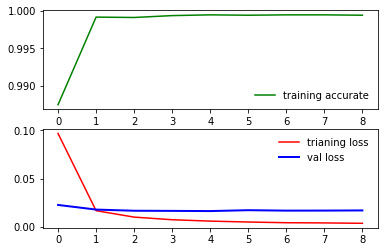

In [21]:
# 可视化训练结果
xiv3net.plot_training_results()

### 8.4测试融合模型

In [22]:
xiv3net.predict_by_gen(test_generator,load_weights=True)

125/125 [==============================] - 145s 1s/step
xiv3net Model test Done!


## ***最终结果***
### 参数列表[val rate:0.1, Optimizer: Adam,Dropout:0.5]

### 各模型的val loss可从以上每个小节训练结果中查看，test score为kaggle中提交的得分，可以得出，融合后的模型效果最好，val loss降到了0.01625，最终kaggle得分为0.03738.

In [23]:
dt = pd.DataFrame({
    'models:':['VGG19','ResNet50','InceptionV3','Xception','Inceptionv3_Xception'],
    'val loss':[0.05668,0.03310,0.02275,0.01985,0.01625],
    'test score':[0.08114,0.05515,0.04436,0.04010,0.03738]
})
print(dt)

                models:  test score  val loss
0                 VGG19     0.08114   0.05668
1              ResNet50     0.05515   0.03310
2           InceptionV3     0.04436   0.02275
3              Xception     0.04010   0.01985
4  Inceptionv3_Xception     0.03738   0.01625


## 9.增加对比试验
### 对最终模型进行参数调整
### 需要对比的参数有：验证集比例及dropout

### 9.1验证集比率 [0.1, 0.2]，固定 dropout = 0.5

In [47]:
# val_rate = 0.1
dt = Dataset()
files = pkl.load(open('outliers.pkl','rb'))
dt.filelist = files['pure_files']
dt.split_val_data(random_seed=333,val_rate=0.1)

Total training images:22452
Total val images:2495
Total test images:12500


In [48]:
xiv3net = XIV3net(parms)

In [49]:
# 重新定义名字，以免覆盖之前的结果
xiv3net.info = 'val_rate_0.1_xiv3net'
xiv3net.upgrade_paths()

In [39]:
# 训练
xiv3net.train_generator(train_generator,val_generator,val_rate=0.1)

Epoch 1/10
225/225 [==============================] - 276s 1s/step - loss: 0.1238 - binary_accuracy: 0.9704 - val_loss: 0.0245 - val_binary_accuracy: 0.9940

Epoch 00001: val_loss improved from inf to 0.02448, saving model to /data/glj/dogsVScats/results/xiv3net/val_rate_0.1_xiv3net_weights_pretrained.best.h5
Epoch 2/10
225/225 [==============================] - 261s 1s/step - loss: 0.0202 - binary_accuracy: 0.9982 - val_loss: 0.0212 - val_binary_accuracy: 0.9932

Epoch 00002: val_loss improved from 0.02448 to 0.02118, saving model to /data/glj/dogsVScats/results/xiv3net/val_rate_0.1_xiv3net_weights_pretrained.best.h5
Epoch 3/10
225/225 [==============================] - 261s 1s/step - loss: 0.0122 - binary_accuracy: 0.9984 - val_loss: 0.0207 - val_binary_accuracy: 0.9924

Epoch 00003: val_loss improved from 0.02118 to 0.02069, saving model to /data/glj/dogsVScats/results/xiv3net/val_rate_0.1_xiv3net_weights_pretrained.best.h5
Epoch 4/10
225/225 [==============================] - 262s 

### 结果表明val rate=0.1表现不如0.2
### val loss = 0.01873 < val loss 0.01625

### 9.2验证 dropout[0.1,0.3,0.5,0.7,0.9] ，固定val rate = 0.2

In [31]:
# val_rate = 0.2
dt = Dataset()
files = pkl.load(open('outliers.pkl','rb'))
dt.filelist = files['pure_files']
dt.split_val_data(random_seed=333,val_rate=0.2)

Total training images:19957
Total val images:4990
Total test images:12500


In [32]:
# 初始化参数
parms = {
    'learning_rate': 0.0001,
    'batch_size': 100,
    'epoch': 10,
    'verbose': 1
}
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [34]:
dropout_rate = [0.1,0.3,0.5,0.7,0.9]
for rate in dropout_rate:
    # 创建训练集数据生成器
    train_generator = dt.data_generator(batch_size=parms['batch_size'],
                                        mode='train',shape=(299,299),
                                        preprocess_input=xception.preprocess_input)
    # 创建验证集数据生成器
    val_generator = dt.data_generator(batch_size=parms['batch_size'],
                                      mode='val',shape=(299,299),
                                      preprocess_input=xception.preprocess_input)
    xiv3net = XIV3net(parms,rate)
    print(xiv3net.dropout_rate)
    xiv3net.info = 'dropout_rate_'+str(rate)+'_xiv3net'
    xiv3net.upgrade_paths()
    xiv3net.train_generator(train_generator,val_generator,val_rate=0.2)
    print('dropout_rate {} trained done!'.format(xiv3net.dropout_rate))

0.1
Epoch 1/10
200/200 [==============================] - 285s 1s/step - loss: 0.1157 - binary_accuracy: 0.9796 - val_loss: 0.0242 - val_binary_accuracy: 0.9946

Epoch 00001: val_loss improved from inf to 0.02424, saving model to /data/glj/dogsVScats/results/xiv3net/dropout_rate_0.1_xiv3net_weights_pretrained.best.h5
Epoch 2/10
200/200 [==============================] - 271s 1s/step - loss: 0.0187 - binary_accuracy: 0.9990 - val_loss: 0.0183 - val_binary_accuracy: 0.9942

Epoch 00002: val_loss improved from 0.02424 to 0.01834, saving model to /data/glj/dogsVScats/results/xiv3net/dropout_rate_0.1_xiv3net_weights_pretrained.best.h5
Epoch 3/10
200/200 [==============================] - 270s 1s/step - loss: 0.0109 - binary_accuracy: 0.9992 - val_loss: 0.0168 - val_binary_accuracy: 0.9944

Epoch 00003: val_loss improved from 0.01834 to 0.01677, saving model to /data/glj/dogsVScats/results/xiv3net/dropout_rate_0.1_xiv3net_weights_pretrained.best.h5
Epoch 4/10
200/200 [=======================

### 读取结果并展示

0.0168114560901
0.0168677689027
0.0165023766414
0.0170790273917
0.0170077168042


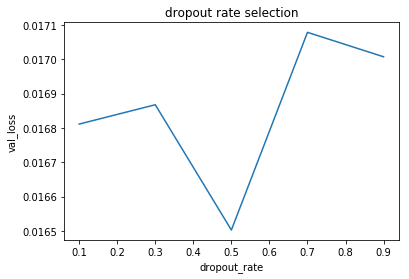

In [35]:
import pickle as pkl
from matplotlib import pyplot as plt
%matplotlib inline
dropout_rate = [0.1,0.3,0.5,0.7,0.9]
val_losses = []
for rate in dropout_rate:
    info = 'dropout_rate_'+str(rate)+'_xiv3net'
    hist_name = 'results/xiv3net/hist_'+info+'_weights_pretrained.pkl'
    with open(hist_name,'rb') as f:
        hist = pkl.load(f)
        val_loss = hist['val_loss'][-1]
        print(val_loss)
        val_losses.append(val_loss)
        
plt.plot(dropout_rate,val_losses)
plt.xlabel('dropout_rate')
plt.ylabel('val_loss')
plt.title('dropout rate selection')
plt.show()